In [12]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import math as m

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

### 분석 과정

1. Y00 ~ Y17의 중앙값으로 Y18값 대체
  - 중앙값 : 이상치에 민감하지 않는 방법

2. feature 전처리
  - 평균
    - 현지 기압
      - 1,6 / 22,29
    - 해면 기압
      - 5,8,9,23,33
    - 누적 일사량
      - 11,34
  
  - Drop columns
    - 현지 기압
    - 해면 기압
    - 누적 일사량

==> shift

==> model


In [101]:
result_processing_model = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/result_processing_model.csv').values.tolist()
result_processing_model

[['Drop3,4 median / Best / lgb', 7.94493626458693]]

In [0]:
def lgb_model(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.01
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=10,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  feature_importance = pd.DataFrame({'name' : lgb_model.feature_name(),
                                   'importance' : lgb_model.feature_importance()}).sort_values(by = 'importance', ascending = False)
  
  return pred, feature_importance

In [0]:
def best_data_processing(X_data):
  # 현지 기압 평균
  X_data['Mean_01_06'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['Mean_22_29'] = X_data[['X22','X29']].mean(axis = 1)
  # 해면 기압 평균
  X_data['Mean_05_08_09_23_33'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  # 누적 일사량 평균
  X_data['Mean_11_34'] = X_data[['X11','X34']].mean(axis = 1)
  
  # 풍향 삭제
  X_data = X_data.drop(['X13'], axis = 1) # ,'X15','X17','X25','X35'
  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X29'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)

  return X_data

In [0]:
def data_processing(X_data):
  # 풍향 North_South / East_West
  # X13은 영향이 없다고 판단
  # X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
  # X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

  # X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
  # X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

  # X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
  # X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

  # X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
  # X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

  # 현지 기압 평균
  X_data['Mean_01_06'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['Mean_22_29'] = X_data[['X22','X29']].mean(axis = 1)
  # 해면 기압 평균
  X_data['Mean_05_08_09_23_33'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  # 누적 일사량 평균
  X_data['Mean_11_34'] = X_data[['X11','X34']].mean(axis = 1)
  
  # 풍향 삭제
  X_data = X_data.drop(['X13'], axis = 1) # ,'X15','X17','X25','X35'
  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X29'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)

  return X_data

In [0]:
All_Y = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09','Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']
Drop_3_4 = ['Y00', 'Y01', 'Y02', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09','Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']

In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, Y].median(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

######  -- 설정 --  ######
tmp_processing = data_processing
tmp_model = lgb_model
tmp_Y = All_Y

new_X = tmp_processing(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = tmp_model(X_train, Y_train, X_test)

7.94493626458693
                   name  importance
28           Mean_11_34       11724
0                   X00       10351
22                  X37        9913
20                  X35        9539
7                   X15        9220
19                  X32        9176
6                   X12        9150
4                   X07        8923
10                  X20        8874
23                  X38        8847
18                  X31        8558
17                  X30        7832
8                   X17        7676
13                  X25        7355
16                  X28        7015
1                   X02        6988
9                   X18        6984
2                   X03        6626
15                  X27        6317
14                  X26        5936
12                  X24        5636
26           Mean_22_29        5205
25           Mean_01_06        5195
27  Mean_05_08_09_23_33        3936
5                   X10         407
3                   X04         243
11         

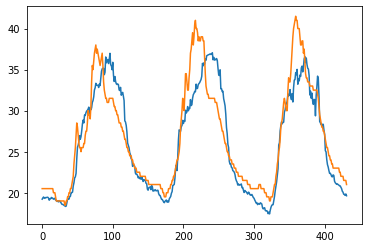

In [109]:
Y_test.index = range(len(Y_pred))
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
mse = (np.array(list(map(lambda x : 0 if x <= 1 and x >= -1 else x, (Y_pred - np.array(Y_test['Y18']))))) ** 2).mean()
result_processing_model.append(['All median / Best / lgb',mse])
print(mse)
print(feature_importance)

In [110]:
result_processing_model = pd.DataFrame(result_processing_model, columns = ['name','mse']).set_index('name').sort_values('mse')
result_processing_model.to_csv('/content/gdrive/My Drive/Colab Notebooks/result_processing_model.csv')
result_processing_model

,mse
name,
"Drop3,4 median / Best / lgb",7.944936
All median / Best / lgb,7.944936


In [82]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, Y].median(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

# 4300개의 예측값 + Y_의 실제값
before = train_dt.loc[:4319, Y].median(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

X_train = tmp_processing(X.copy())
print(len(X_train))

Y_train = pd.concat([before, after],ignore_index=True)
print(len(Y_train))

X_test = tmp_processing(test_dt.copy())
print(len(X_test))

4752
4752
11520


In [0]:
Y_pred, feature_importance = tmp_model(X_train, Y_train, X_test)

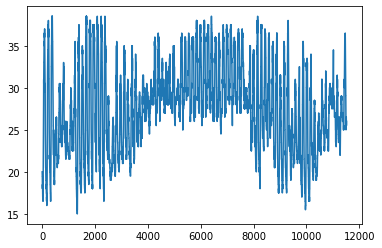

In [85]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/result.csv')

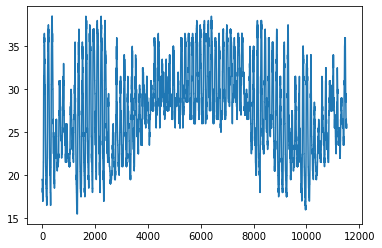

In [59]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/result.csv')